In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os, shutil
import keras
import numpy as np
import tensorflow as tf
from keras import layers
from keras.utils import image_dataset_from_directory

In [3]:
!unzip data.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/surprise/Training_93037336.jpg  
  inflating: train/surprise/Training_93055491.jpg  
  inflating: train/surprise/Training_93101746.jpg  
  inflating: train/surprise/Training_93122504.jpg  
  inflating: train/surprise/Training_93172846.jpg  
  inflating: train/surprise/Training_93342559.jpg  
  inflating: train/surprise/Training_9340355.jpg  
  inflating: train/surprise/Training_93417164.jpg  
  inflating: train/surprise/Training_93442446.jpg  
  inflating: train/surprise/Training_93492148.jpg  
  inflating: train/surprise/Training_93560263.jpg  
  inflating: train/surprise/Training_93625752.jpg  
  inflating: train/surprise/Training_93642020.jpg  
  inflating: train/surprise/Training_93658821.jpg  
  inflating: train/surprise/Training_93675722.jpg  
  inflating: train/surprise/Training_93699149.jpg  
  inflating: train/surprise/Training_93735232.jpg  
  inflating: train/surprise/Training_93744466.jpg  
  inflating: t

In [4]:
train_dir = os.path.join("train")
val_dir = os.path.join("val")

train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(48, 48),
    label_mode="categorical",
    color_mode='grayscale',
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    val_dir,
    image_size=(48, 48),
    label_mode="categorical",
    color_mode='grayscale',
    batch_size=32)

Found 19200 files belonging to 6 classes.
Found 4806 files belonging to 6 classes.


In [5]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [6]:
inputs = keras.Input(shape=(48, 48, 1))
x = data_augmentation(inputs) # apply data augmentation
x = layers.Rescaling(1./255)(x) # apply input scaling
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)
# ^^we need this first Conv2D layer otoo process RGB, since separable convolutions assume
# that feature channels are independent, but RGB is actually highly correlated
for size in [32, 64, 128, 256, 512]: # increasing feature depth
    residual = x
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])
x = layers.GlobalAveragePooling2D()(x) # we do gloal average pooling instead of flatten
x = layers.Dropout(0.5)(x) # for regularization
outputs = layers.Dense(6, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"]
              )

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 sequential (Sequential)     (None, 48, 48, 1)            0         ['input_1[0][0]']             
                                                                                                  
 rescaling (Rescaling)       (None, 48, 48, 1)            0         ['sequential[0][0]']          
                                                                                                  
 conv2d (Conv2D)             (None, 44, 44, 32)           800       ['rescaling[0][0]']           
                                                                                              

In [8]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="model.h5",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks
)


Epoch 1/100
600/600 [==============================] - ETA: 0s - loss: 1.6824 - accuracy: 0.2863

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


600/600 [==============================] - 271s 443ms/step - loss: 1.6824 - accuracy: 0.2863 - val_loss: 2.5456 - val_accuracy: 0.1933
Epoch 2/100
600/600 [==============================] - 276s 460ms/step - loss: 1.5128 - accuracy: 0.3802 - val_loss: 1.5870 - val_accuracy: 0.3577
Epoch 3/100
600/600 [==============================] - 275s 459ms/step - loss: 1.4162 - accuracy: 0.4312 - val_loss: 1.3771 - val_accuracy: 0.4340
Epoch 4/100
600/600 [==============================] - 272s 454ms/step - loss: 1.3664 - accuracy: 0.4549 - val_loss: 1.4049 - val_accuracy: 0.4295
Epoch 5/100
600/600 [==============================] - 270s 450ms/step - loss: 1.3244 - accuracy: 0.4717 - val_loss: 1.2603 - val_accuracy: 0.5035
Epoch 6/100
600/600 [==============================] - 265s 442ms/step - loss: 1.2913 - accuracy: 0.4885 - val_loss: 1.2910 - val_accuracy: 0.4952
Epoch 7/100
600/600 [==============================] - 271s 451ms/step - loss: 1.2653 - accuracy: 0.5057 - val_loss: 1.2640 - val_

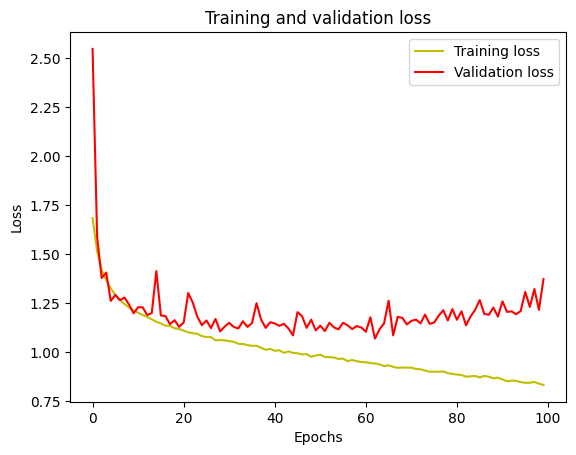

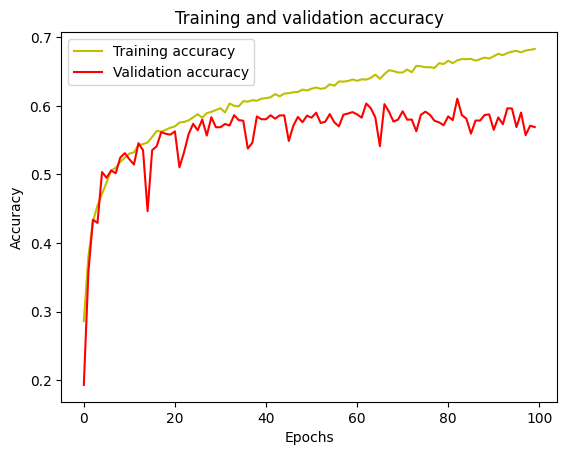

In [12]:
import matplotlib.pyplot as plt

# Plotting training and validation loss
plt.plot(history.history["loss"], "y", label="Training loss")
plt.plot(history.history["val_loss"], "r", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.plot(history.history["accuracy"], "y", label="Training accuracy")
plt.plot(history.history["val_accuracy"], "r", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
